In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings('ignore')
import dtale
import math 

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from itertools import product
from pandas_profiling import ProfileReport
# from prince import MCA

%config InlineBackend.figure_format = 'retina'

# Seeting seaborn style
sns.set()

from datetime import datetime
# import calendar
# import missingno as msno
from sklearn.impute import SimpleImputer
import scipy.stats as ss


from helper_functions import *
template = "plotly_dark"

colors = (["#505050", "#d1675b"])
import plotly.express as px
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_pickle("datasets/data_EDA.pkl")

In [9]:
features = ['DOMAIN', 'STATE', 'AGE', 'INCOME', 'GENDER', 'RECENCY', 'FREQUENCY', 'AMOUNT', 'RAMNTALL', 
            'NGIFTALL', 'LASTGIFT', 'AVGGIFT', 'LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']
pca_features = ['AGEC6', 'HHD7', 'HHD11', 'LFC3', 'LFC4', 'LFC5', 
                'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7', 'EC8' ]
metric_features = ['AGE','RAMNTALL', 'LASTGIFT', 'NGIFTALL',  'AVGGIFT','LASTDATE_MONTHS', 'FIRSTDATE_MONTHS']

data_fin = data[features + pca_features].copy().reset_index(drop=True)

#### PCA for Census data 

In [10]:
# Scale metric variables and variables chosen for PCA
scaler = StandardScaler()
pca_columns = data[pca_features].copy()

pca_columns = pd.DataFrame(scaler.fit_transform(pca_columns),
                           columns = pca_columns.columns,
                           index = pca_columns.index)
data_fin[metric_features] = pd.DataFrame(scaler.fit_transform(data_fin[metric_features]),
                           columns = data_fin[metric_features].columns,
                           index = data_fin[metric_features].index)

In [11]:
# Print normalized PCA columns
pca_columns

,AGEC6,HHD7,HHD11,LFC3,LFC4,LFC5,EC2,EC3,EC4,EC5,EC6,EC7,EC8
0,0.076568,-0.354471,-0.417101,-0.442595,-0.392213,-0.656144,0.873613,-0.374842,1.000212,0.027784,0.426383,-1.035283,-0.618552
1,-1.092023,-0.731600,-1.595278,0.141145,0.747168,0.292063,-0.455339,-1.032706,-1.634836,0.027784,0.132215,1.638585,1.793472
2,-0.090373,-0.165907,-0.202887,0.214113,0.009921,0.219124,1.598495,0.940887,-0.073326,-0.675346,-0.161954,-0.932442,-0.618552
3,-0.591198,-0.354471,-0.738422,-0.223693,-0.124124,-0.583205,2.323378,-0.111696,-1.439647,0.871540,1.014719,-1.138124,-0.334785
4,0.243510,2.285432,0.439755,-0.369628,-0.325191,-0.291449,0.873613,0.940887,0.121863,-1.097224,-1.044458,-0.212554,-0.334785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,-1.258965,0.776916,-0.417101,1.235659,0.881213,1.167331,-0.817780,-0.769560,-0.073326,1.715296,0.426383,0.095969,0.090867
93363,-1.092023,-1.108729,-1.488171,-0.004790,1.149302,-0.072632,-0.938594,-0.901133,-1.634836,0.449662,0.132215,2.255632,0.942169
93364,-0.257315,1.531174,0.118434,0.943789,0.009921,1.167331,-0.455339,-1.295852,2.171344,0.309036,0.132215,-0.315395,-1.044204
93365,-0.591198,0.022658,-0.738422,0.287080,1.015258,0.292063,-0.213712,-0.901133,-0.854081,1.996548,1.603056,0.095969,-0.334785


In [12]:
pca = PCA()
pca_feat = pca.fit_transform(pca_columns)

In [13]:
# PCA components
pd.DataFrame(pca_feat, columns=[f"PC{i}" for i in range(pca.n_components_)])

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,1.229230,-0.354019,-0.984593,-0.687497,0.082377,0.505255,-0.561440,0.339789,-0.738562,0.060609,0.484727,-0.226863,0.141877
1,-2.837532,1.138767,1.343151,-1.764001,0.271681,-0.020729,-0.084022,-0.533287,0.100432,-0.233004,0.110944,-0.299724,-0.077838
2,1.294051,-1.138463,0.609932,-0.225549,-0.386620,0.587517,-1.008136,-0.385532,0.336447,0.348104,0.245396,0.051304,-0.024873
3,0.512757,-0.404120,0.502596,-0.726813,1.664456,0.901030,-2.449830,-0.320040,-0.263024,0.275356,1.002778,-0.121703,0.216712
4,2.035552,-0.830684,1.634460,0.689069,0.220790,-0.414330,0.908922,-0.361580,-0.608173,-0.123332,-0.540688,0.232774,-0.172846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,-2.456935,-1.479421,-0.317714,0.301780,0.847557,-0.965094,0.016380,0.379443,-0.318499,0.117496,0.331177,-0.017781,0.003664
93363,-3.031438,1.282531,0.760139,-1.720516,0.390294,-0.284158,-0.409188,-0.292098,0.489023,-0.822026,-0.797961,-0.321566,0.101140
93364,-0.415545,-2.037935,-1.190216,0.605967,-0.329027,-0.480328,1.107956,1.001969,-1.773087,0.704991,-0.459059,0.072000,-0.213146
93365,-2.096431,-0.555150,-0.934039,-0.113246,1.782872,0.120059,-1.115936,-0.110799,-0.327842,-0.410454,0.164775,0.126437,-0.003923


In [14]:
# Output PCA eigenvalues
pd.DataFrame( {"Eigenvalues": pca.explained_variance_,}, 
             index=range(1, pca.n_components_ + 1)).T

,1,2,3,4,5,6,7,8,9,10,11,12,13
Eigenvalues,4.653096,2.512183,1.288395,1.076649,0.895184,0.700412,0.472446,0.422127,0.352648,0.29304,0.243403,0.07523,0.015326


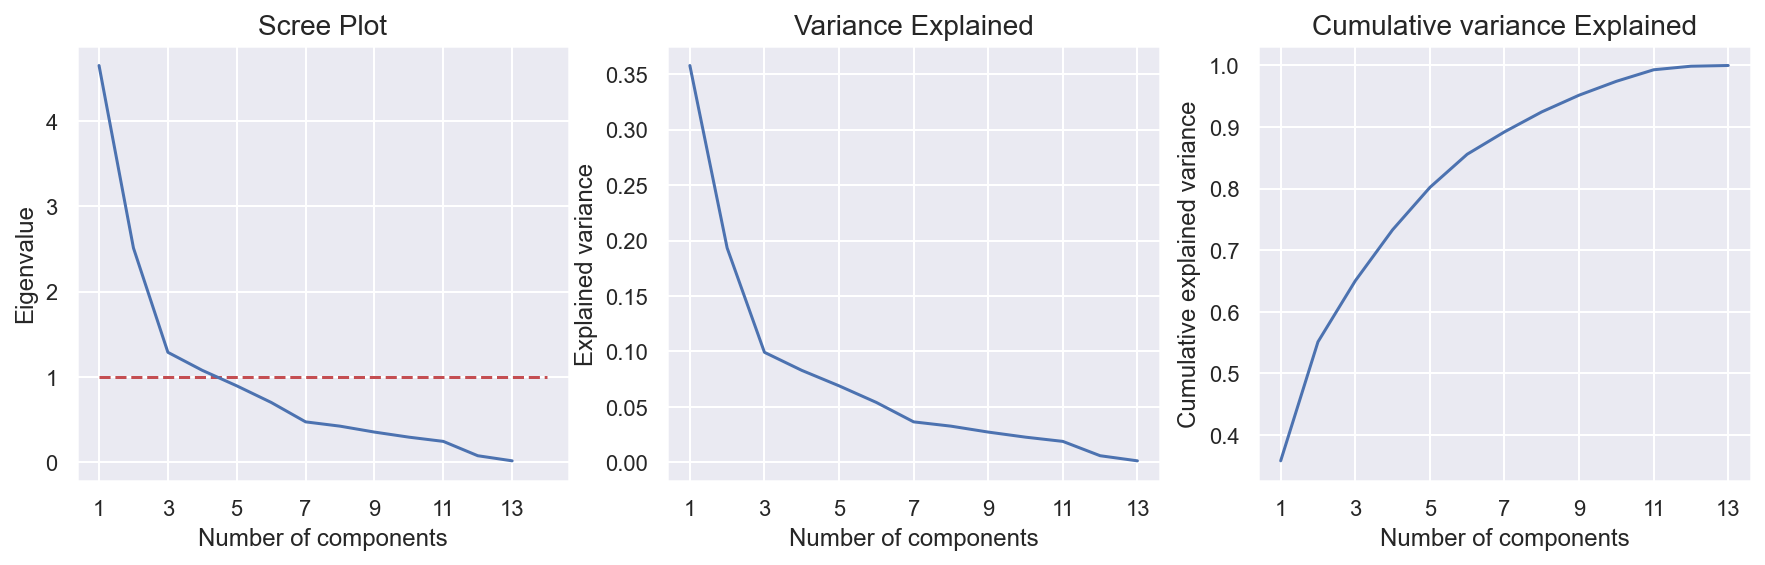

In [15]:
# Figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Build plots
ax1.plot(pca.explained_variance_)
ax1.hlines(1, 0, 13, colors="r", linestyles="dashed")
ax2.plot(pca.explained_variance_ratio_)
ax3.plot(np.cumsum(pca.explained_variance_ratio_))

# Plots customization
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax3.set_title("Cumulative variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Explained variance")
ax3.set_ylabel("Cumulative explained variance")
ax1.set_xlabel("Number of components")
ax2.set_xlabel("Number of components")
ax3.set_xlabel("Number of components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax3.set_xticks(range(0, pca.n_components_, 2))
ax3.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

From graphs we see that number of components t retain - between 4-7

Using Kaiser’s Criterion, where PCs with an eigenvector greater than 1.0 should be retained we are going to leave first 4 PCs.
https://en.wikipedia.org/wiki/Factor_analysis#Older_methods

In [16]:
# Perform PCA with 4 principal components
pca = PCA(n_components = 4)
pca_feat = pca.fit_transform(pca_columns)
pca_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=pca_columns.index, columns=pca_names)  
pca_df

,PC0,PC1,PC2,PC3
0,1.229230,-0.354019,-0.984593,-0.687497
1,-2.837532,1.138767,1.343151,-1.764001
2,1.294051,-1.138463,0.609932,-0.225549
3,0.512757,-0.404120,0.502596,-0.726813
4,2.035552,-0.830684,1.634460,0.689069
...,...,...,...,...
93362,-2.456935,-1.479421,-0.317714,0.301780
93363,-3.031438,1.282531,0.760139,-1.720516
93364,-0.415545,-2.037935,-1.190216,0.605967
93365,-2.096431,-0.555150,-0.934039,-0.113246


In [18]:
# Merge data_fin with pca variables to check their relationship
df_pca = pd.concat([data_fin, pca_df], axis=1)
df_pca.head()

,DOMAIN,STATE,AGE,INCOME,GENDER,RECENCY,FREQUENCY,AMOUNT,RAMNTALL,NGIFTALL,...,EC3,EC4,EC5,EC6,EC7,EC8,PC0,PC1,PC2,PC3
0,T2,IL,0.034385,6,0,L,4,E,1.148089,2.505245,...,10,39,21,8,4,3,1.229230,-0.354019,-0.984593,-0.687497
1,S1,CA,-0.904638,6,1,L,2,G,-0.485953,-0.771696,...,5,12,21,7,30,20,-2.837532,1.138767,1.343151,-1.764001
2,R2,NC,-0.166834,3,1,L,4,E,0.826361,2.037111,...,20,28,16,6,5,3,1.294051,-1.138463,0.609932,-0.225549
3,R2,CA,0.705116,1,0,L,4,E,0.038973,0.749741,...,12,14,27,10,3,5,0.512757,-0.404120,0.502596,-0.726813
4,S2,FL,1.241701,3,0,L,2,F,1.266621,3.207447,...,20,30,13,3,12,5,2.035552,-0.830684,1.634460,0.689069


In [19]:
# Correlation of each Principal Component with metric and pca_features
loadings = df_pca[pca_features + pca_names].corr(method='pearson').loc[pca_features, pca_names]
loadings

,PC0,PC1,PC2,PC3
AGEC6,0.471628,0.535459,-0.394311,0.309864
HHD7,0.288479,-0.560141,0.373256,0.281320
HHD11,0.209478,0.311165,0.130661,0.842339
LFC3,-0.725787,-0.581368,0.062349,0.188707
LFC4,-0.730362,-0.448072,0.040745,0.034277
LFC5,-0.765905,-0.518234,0.025926,0.172330
EC2,0.669529,-0.281299,0.408916,0.013504
EC3,0.726904,-0.408104,0.109191,0.187118
EC4,0.441350,-0.472998,-0.542581,-0.002954
EC5,-0.542847,0.002131,-0.442648,0.277448


In [20]:
# Merge data_fin with pca variables
data_fin = pd.concat([data_fin, pca_df], axis=1)
data_fin

,DOMAIN,STATE,AGE,INCOME,GENDER,RECENCY,FREQUENCY,AMOUNT,RAMNTALL,NGIFTALL,...,EC3,EC4,EC5,EC6,EC7,EC8,PC0,PC1,PC2,PC3
0,T2,IL,0.034385,6,0,L,4,E,1.148089,2.505245,...,10,39,21,8,4,3,1.229230,-0.354019,-0.984593,-0.687497
1,S1,CA,-0.904638,6,1,L,2,G,-0.485953,-0.771696,...,5,12,21,7,30,20,-2.837532,1.138767,1.343151,-1.764001
2,R2,NC,-0.166834,3,1,L,4,E,0.826361,2.037111,...,20,28,16,6,5,3,1.294051,-1.138463,0.609932,-0.225549
3,R2,CA,0.705116,1,0,L,4,E,0.038973,0.749741,...,12,14,27,10,3,5,0.512757,-0.404120,0.502596,-0.726813
4,S2,FL,1.241701,3,0,L,2,F,1.266621,3.207447,...,20,30,13,3,12,5,2.035552,-0.830684,1.634460,0.689069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93362,C2,AK,-0.099761,1,1,L,1,G,-0.672216,-1.005763,...,7,28,33,8,15,8,-2.456935,-1.479421,-0.317714,0.301780
93363,C1,TX,-0.770492,7,1,L,1,F,-0.714549,-1.005763,...,6,12,24,7,36,14,-3.031438,1.282531,0.760139,-1.720516
93364,C3,MI,0.034385,5,1,A,3,E,-0.392821,-0.303561,...,3,51,23,7,11,0,-0.415545,-2.037935,-1.190216,0.605967
93365,C1,CA,-0.099761,7,0,A,4,F,3.332457,3.675581,...,6,20,35,12,15,5,-2.096431,-0.555150,-0.934039,-0.113246


In [21]:
# Create our SES score based on first PCA component
cut_labels_4 = ['1', '2', '3', '4']

std = np.std(data_fin.PC0)
cut_bins = [-math.inf, (-1)*std, 0, std, math.inf]
data_fin['SES'] = pd.cut(data_fin.PC0, bins=cut_bins, labels=cut_labels_4)

In [22]:
# Cramer's V - implemetation was taken from link - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [23]:
# To explore accosiation between categorical variables and our new SES score
# we build Correlation matrix based on Cramer's V for all categorical variables 
rows = []
cat_features = ['DOMAIN', 'STATE', 'INCOME', 'GENDER', 'RECENCY', 'AMOUNT', 'SES']
dataframe = data_fin[cat_features].copy()

for var1 in dataframe:
    col = []
    for var2 in dataframe :
        cramers =cramers_v(dataframe[var1], dataframe[var2]) # Cramer's V
        col.append(round(cramers,3)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_array = np.array(rows)
dataframe = pd.DataFrame(cramers_array, columns = dataframe.columns, index = dataframe.columns)

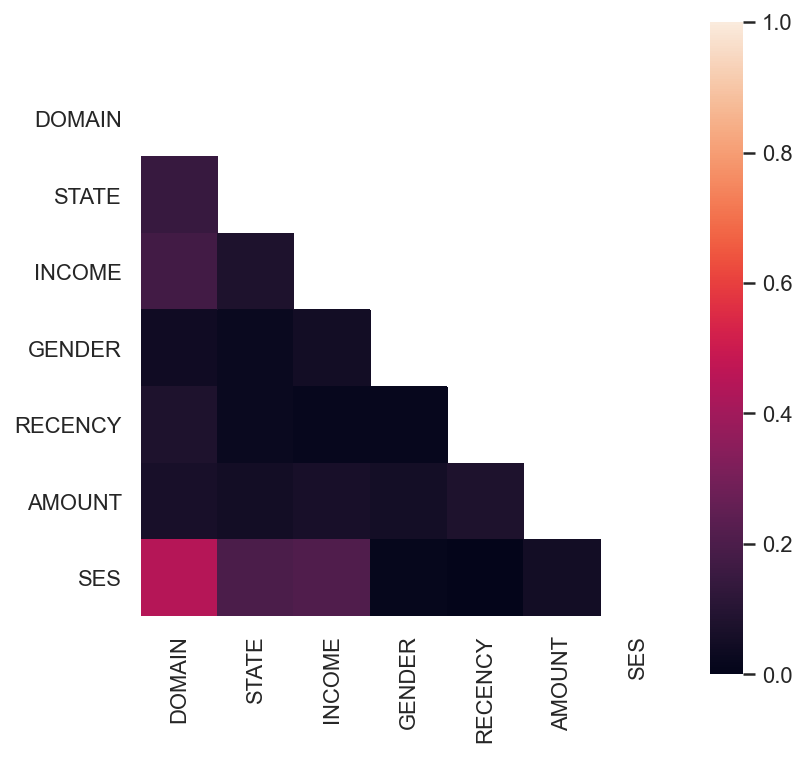

In [24]:
# Build heatmap plot to visualize association matrix for categorical features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
mask = np.zeros_like(dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(dataframe, mask = mask, vmin = 0., vmax=1, square=True)

plt.show()

In [ ]:
data.to_pickle("datasets/data_pca.pkl")

In [ ]:
xs = pca_columns

In [ ]:
xs_pca = PCA(n_components=2, random_state=42).fit_transform(xs)
px.scatter(x= xs_pca[:, 0], y=xs_pca[:, 1], opacity=0.5, color_continuous_scale=["#505050", "#d1675b"], height=500, width=500, template="ggplot2")


In [ ]:
xs_pca = PCA(n_components=3, random_state=42).fit_transform(xs)
fig = px.scatter_3d(
    x=xs_pca[:, 0],
    y=xs_pca[:, 1],
    z=xs_pca[:, 2],
    opacity=0.1,
    color_discrete_sequence=colors,
    height=1000,
    template="ggplot2",
    width=1000,
)

fig.update_traces(
    marker=dict(size=4),
)

fig.show()

In [ ]:
xs_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=25, n_iter=1000, ).fit_transform(xs[:10000])

In [ ]:
fig = px.scatter(
    x=xs_tsne[:, 0],
    y=xs_tsne[:, 1],
    opacity=0.8,
    color_continuous_scale=["#505050", "#d1675b"],
    height=1000,
    template="ggplot2",
    width=1000,
)
fig.update_layout(
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"}
)
fig.update_traces(
    marker=dict(size=5),
)

fig.show()